# Generate Basic plots
## Requirements

* Fio must have only one job
* Fio output format must be json. Default for this repo.
 
## Start with default variables

In [122]:
# absolute path to raw results
raw_results_dir = "../results/rw"
raw_results_dir = "../results/rw"
columns_for_df = [
  "iops",
  "bw",
  "lat_ns.max",
  "lat_ns.mean"
]
fig_size1x2 = (16, 5)

In [123]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tkr
from pprint import pp

In [124]:
def fmt_bytes_per_sec(x, pos):
    if x<0:
        return ""
    for x_unit in ['B/s', 'kB/s', 'MB/s', 'GB/s', 'TB/s']:
        if x < 1024.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1024.0

def fmt_time(x, pos):
    if x<0:
        return ""
    for x_unit in ['ns', 'µs', 'ms', 's']:
        if x<1000.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1000.0


In [125]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [126]:
# load all files in results dir into []{}

json_files = [os.path.join(raw_results_dir, pos_json) for pos_json in os.listdir(raw_results_dir)]
json_files.sort()
json_stats_read = []
json_stats_write = []


for index, js in enumerate(json_files):
  with open(js) as json_file:

    json_val = json.load(json_file)
    if json_val.get("client_stats") != None:
      json_stat = json_val.get("client_stats")[0]
    elif json_val.get("jobs") != None:
      json_stat = json_val.get("jobs")[0]
    else:
      print("incorrect fio json file")
      exit(1)
    json_stats_read.append(json_stat.get("read"))
    json_stats_write.append(json_stat.get("write"))

#clean unused variables
del json_val
del json_stat
del json_file
del json_files
del index
del js

In [127]:
df_read = pd.DataFrame(pd.json_normalize(json_stats_read), columns=columns_for_df)
df_write = pd.DataFrame(pd.json_normalize(json_stats_write), columns=columns_for_df)

del json_stats_read
del json_stats_write

In [128]:
# move bandwitch to Bytes per sec
# see https://fio.readthedocs.io/en/latest/fio_doc.html#json-output
df_read.bw *= 1024
df_write.bw *= 1024
# move lat from ns to ms
# df_read['lat_ns.max'] /= 1000000
# df_read['lat_ns.mean'] /= 1000000
# df_write['lat_ns.max'] /= 1000000
# df_write['lat_ns.mean'] /= 1000000
df_read.rename(columns={'lat_ns.max': 'lat_max', 'lat_ns.mean': 'lat_mean'}, inplace=True)
df_write.rename(columns={'lat_ns.max': 'lat_max', 'lat_ns.mean': 'lat_mean'}, inplace=True)

In [129]:
## this is example for one plot


# fig, ax = plt.subplots()
# ax.set_xlabel("VMs")
# ax.set_ylabel("IOPS")
# ax.set_title("IOPS: mean for all VMs")
# width = 0.4
# ax.bar(x=df_read.index, width=width, height=df_read["iops"],
#         label = 'Read iops', color = 'royalblue')
# ax.bar(x=df_write.index+width, width=width, height=df_write["iops"],
#         label = 'Write iops', color = 'gold')

# ax.axhline(y=np.nanmean(df_read[["iops"]]), linestyle='--',
#             linewidth=2, label='Avg read iops', color = "blue")
# ax.axhline(y=np.nanmean(df_write[["iops"]]), linestyle='--',
#             linewidth=2, label='Avg write iops', color = "orange")
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
# ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
# ax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))
# plt.show()

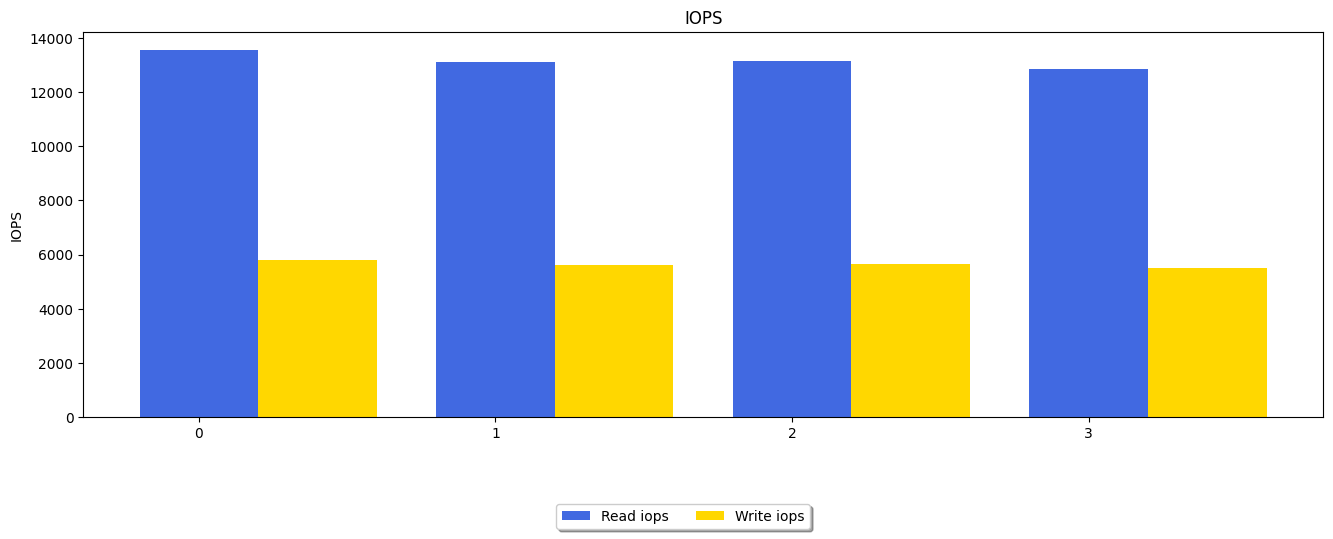

In [130]:
fig, ax = plt.subplots(1, 1, figsize=fig_size1x2)


# common settings for plots
width = 0.4
#ax.set_xlabel("VMs")
ax.set_ylabel("IOPS")
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
ax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))


ax.set_title("IOPS")
ax.bar(x=df_read.index, width=width, height=df_read["iops"],
                label = 'Read iops', color = 'royalblue')
ax.bar(x=df_write.index+width, width=width, height=df_write["iops"],
                label = 'Write iops', color = 'gold')

# ax[0].axhline(y=np.nanmean(df_read[["iops"]]), linestyle='--',
#                 linewidth=2, label='Avg read iops', color = "blue")
# ax[0].axhline(y=np.nanmean(df_write[["iops"]]), linestyle='--',
#                 linewidth=2, label='Avg write iops', color = "orange")



# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

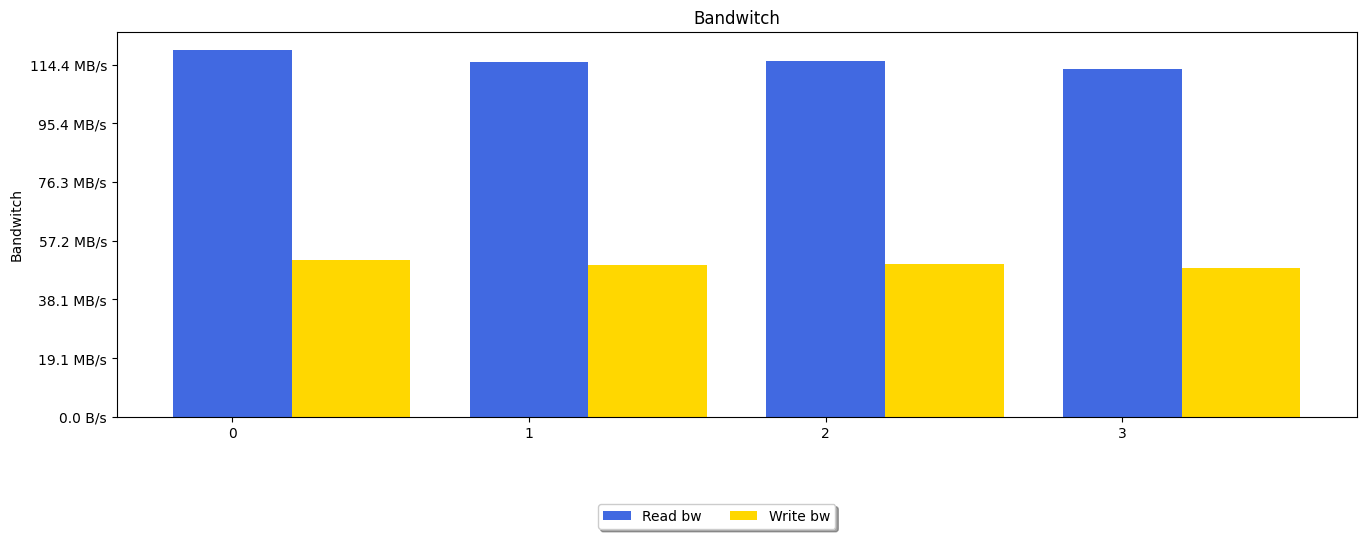

In [131]:
fig, ax = plt.subplots(1, 1, figsize=fig_size1x2)


# common settings for plots
width = 0.4

#ax.set_xlabel("VMs")
ax.set_ylabel("Bandwitch")
ax.yaxis.set_major_formatter(tkr.FuncFormatter(fmt_bytes_per_sec))
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
ax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))
ax.set_title("Bandwitch")

ax.bar(x=df_read.index, width=width, height=df_read["bw"],
                label = 'Read bw', color = 'royalblue')
ax.bar(x=df_write.index+width, width=width, height=df_write["bw"],
                label = 'Write bw', color = 'gold')

# ax[0].axhline(y=np.nanmean(df_read[["bw"]]), linestyle='--',
#                 linewidth=2, label='Avg read bw', color = "blue")
# ax[0].axhline(y=np.nanmean(df_write[["bw"]]), linestyle='--',
#                 linewidth=2, label='Avg write bw', color = "orange")



# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

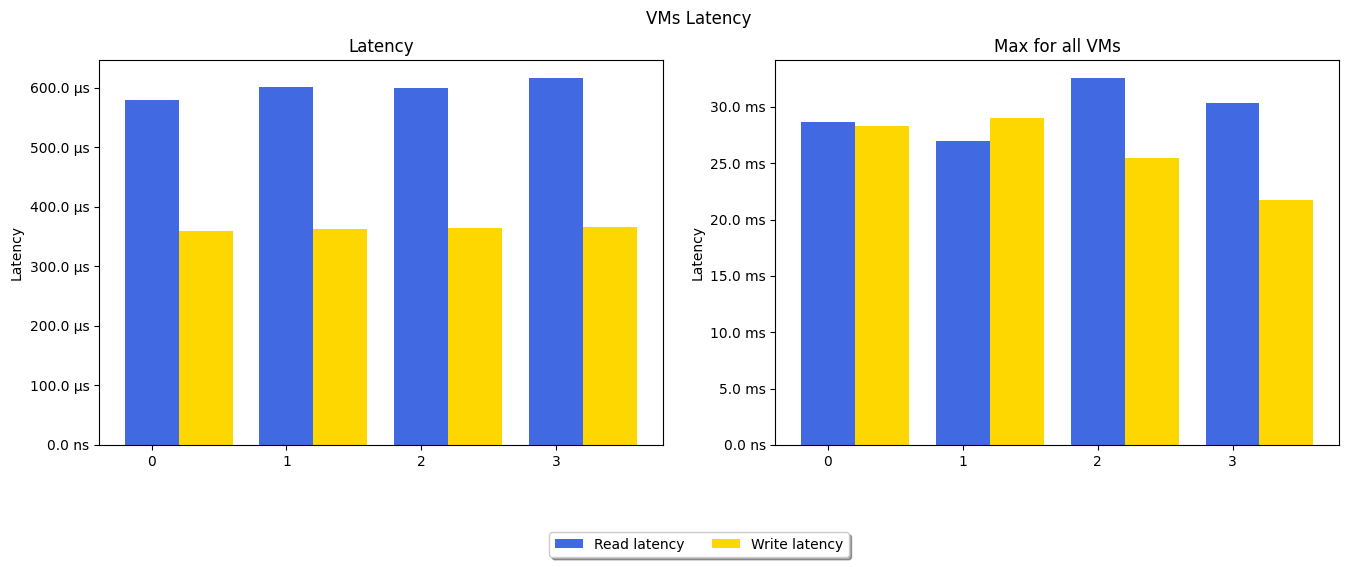

In [134]:
fig, ax = plt.subplots(1, 2, figsize=fig_size1x2)

fig.suptitle('VMs Latency')

# common settings for plots
width = 0.4
for fax in ax:
  #fax.set_xlabel("VMs")
  fax.set_ylabel("Latency")
  fax.yaxis.set_major_formatter(tkr.FuncFormatter(fmt_time))
  fax.xaxis.set_major_locator(tkr.MultipleLocator(1))
  fax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))


ax[0].set_title("Latency")
ax[0].bar(x=df_read.index, width=width, height=df_read["lat_mean"],
                label = 'Read latency', color = 'royalblue')
ax[0].bar(x=df_write.index+width, width=width, height=df_write["lat_mean"],
                label = 'Write latency', color = 'gold')

# ax[0].axhline(y=np.nanmean(df_read[["lat_mean"]]), linestyle='--',
#                 linewidth=2, label='Avg read latency', color = "blue")
# ax[0].axhline(y=np.nanmean(df_write[["lat_mean"]]), linestyle='--',
#                 linewidth=2, label='Avg write latency', color = "orange")



ax[1].set_title("Max for all VMs")
ax[1].bar(x=df_read.index, width=width, height=df_read["lat_max"],
                label = 'Read latency', color = 'royalblue')
ax[1].bar(x=df_write.index+width, width=width, height=df_write["lat_max"],
                label = 'Write latency', color = 'gold')

# ax[1].axhline(y=np.nanmean(df_read[["lat_max"]]), linestyle='--',
#                 linewidth=2, label='Avg read latency', color = "blue")
# ax[1].axhline(y=np.nanmean(df_write[["lat_max"]]), linestyle='--',
#                 linewidth=2, label='Avg write latency', color = "orange")

# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

In [133]:
result = {
  'read': {
    'iops_sum': round(df_read['iops'].sum()),
    'bw_sum': fmt_bytes_per_sec(df_read['bw'].sum(), 0),
    'lat_max_avg': fmt_time(df_read['lat_max'].mean(), 0),
    'lat_mean_avg': fmt_time(df_read['lat_mean'].mean(), 0),
  },
  'write': {
    'iops_sum': round(df_write['iops'].sum()),
    'bw_sum': fmt_bytes_per_sec(df_write['bw'].sum(), 0),
    'lat_max_avg': fmt_time(df_write['lat_max'].mean(), 0),
    'lat_mean_avg': fmt_time(df_write['lat_mean'].mean(), 0),
  }
}

pp(result)

{'read': {'iops_sum': 52691,
          'bw_sum': '463.1 MB/s',
          'lat_max_avg': '29.6 ms',
          'lat_mean_avg': '598.7 µs'},
 'write': {'iops_sum': 22583,
           'bw_sum': '198.5 MB/s',
           'lat_max_avg': '26.1 ms',
           'lat_mean_avg': '362.8 µs'}}


In [152]:
import scipy.stats as stats

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(df_read.T)

,0,1,2,3
0,0.0,0.0,0.0008,0.0004
1,0.0,0.0,0.0012,0.0006
2,0.0008,0.0012,0.0,0.0001
3,0.0004,0.0006,0.0001,0.0


In [159]:
import scipy.stats as stats

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.ttest_ind(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(df_read.T)

,0,1,2,3
0,1.0,0.9742,0.9986,0.9783
1,0.9742,1.0,0.9724,0.9956
2,0.9986,0.9724,1.0,0.9765
3,0.9783,0.9956,0.9765,1.0
